# Tutorial 1 - WaveBot
The goal of this tutorial is to familiarize new users with how to set up and run optimization problems using WecOptTool. 
It uses a one-body WEC, the WaveBot, in one degree of freedom in regular waves. 

![WaveBot Photo](https://live.staticflickr.com/65535/51855905347_de87ccaaba_z.jpg)

At the end of this tutorial the user will perform control co-design of the WEC's geometry and a corresponding optimal controller to maximize electrical power. 
We build up to this problem in three parts of successive complexity:

1. [Optimal control for maximum mechanical power](#1.-Optimal-control-for-maximum-mechanical-power)
2. [Optimal control for maximum electrical power](#2.-Optimal-control-for-maximum-electrical-power)
3. [Control co-design of the WEC's geometry for maximum electrical power](#3.-Control-co-design-of-the-WEC-geometry-for-maximum-electrical-power)

We will start by loading the necessary modules: 

* Import Autograd (wrapper on NumPy, required) for automatic differentiation
* Import other packages we will use in this tutorial 
* Import WecOptTool 

In [26]:
from datetime import datetime

import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.optimize import brute
import scipy

import wecopttool as wot

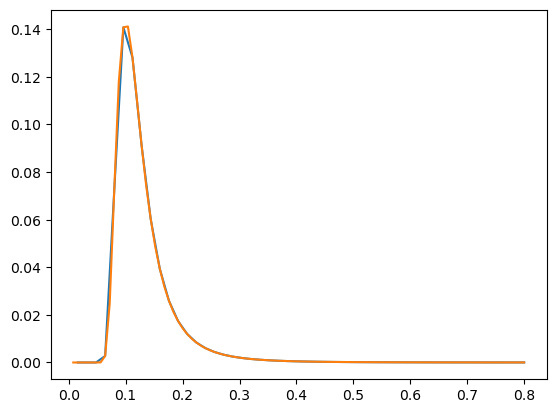

In [27]:
# test integral of spectrum to see how consistent it is
nfreqs = np.linspace(50,100,2)

Hs = .4
Tp = 10
Pspec = []
plt.figure()

for nfreq in nfreqs:
    # first, create waves normally and plot the absorbable power vs. number of frequencies
    f1 = 0.8/nfreq # Hz

    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    fp = 1/Tp
    spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)
    
    ampSpect = abs(waves_irregular.sel(realization=0).values)
    
    plt.plot(freq,efth)
    df = f1
    
    spectInt = sum(df*efth)
    Pspec.append(spectInt)
    


Text(0, 0.5, 'Spectrum Integral')

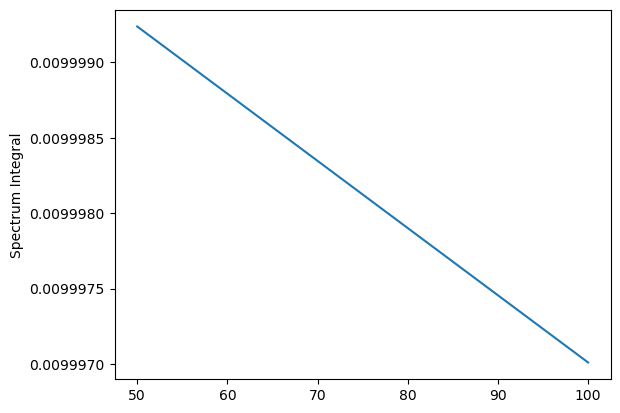

In [28]:
plt.figure()
plt.plot(nfreqs,Pspec)
#print(Pspec)
#plt.ylim([.00998,.009981])
plt.ylabel('Spectrum Integral')

## 1. Optimal control for maximum mechanical power
This example illustrates how to set up, run, and analyze a basic optimization problem within WecOptTool.

The objective of this example is to **find the optimal PTO force time-series** that produces the most mechanical power subject to the WEC dynamics and a maximum force the PTO can exert.

WecOptTool requires the following to be defined to successfully run its optimization routines:
- The WEC object, including all of its properties and constraints
- The wave condition
- The objective function

<div>
<img src="https://live.staticflickr.com/65535/52435098523_37d6a2ca94_k.jpg" width="1000">
</div>

The graphic shows all the requirements for this first part of the tutorial: from the wave on the left, to the objective (mechanical power) on the right.
The WEC object, with all it's components, is illustrated in the middle. The components inside the blue box are the WEC properties that are actually passed on to the optimizer.
In short, the WEC's hydrodynamic properties are modelled by
1. Defining the WEC's geometry
2. Meshing the geometry
3. Obtaining the WEC's BEM cofficients based on the mesh
4. Determening the WEC's intrinsic impedance model based on the BEM coefficients

For this first part of the tutorial, the heave-only, WEC-PTO kinematics are trivial (Unity) and the PTO is assumed to be lossless.

### WEC object
In this section we will create the `WEC` object, which contains all the information about the WEC and its dynamics. This constitutes the vast majority of the setup required to run WecOptTool.

Our `WEC` object requires information about the mesh, degrees of freedom, mass and hydrostatic properties, linear hydrodynamic coefficients (from a BEM solution), any additional dynamic forces (e.g. PTO force, mooring, non-linear hydrodynamics), and constraints (e.g. maximum PTO extension). 
In this case, the only additional force will be the PTO force and the only constraint will be a maximum PTO force of $2,000 N$.

#### Mesh
First, we will create a surface mesh for the hull and store it using the `FloatingBody` object from Capytaine. The WaveBot mesh is pre-defined in the `wecopttool.geom` module, so we will call it directly from there. We will only model the heave degree of freedom in this case. Note that the Capytaine `from_meshio` method can also import from other file types (STL, VTK, MSH, etc.)

In [29]:
wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

At this point we can visualize the mesh for inspection.
Capytaine has built-in methods for visualizing meshes (`fb.show`, and `fb.show_matplotlib`). 
When running outside a Notebook, these are interactive.  
The included WaveBot example also has a method for plotting the cross-section of the device. 

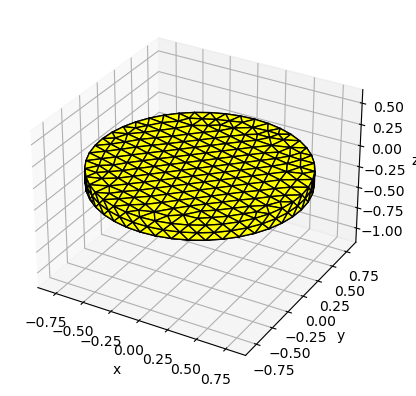

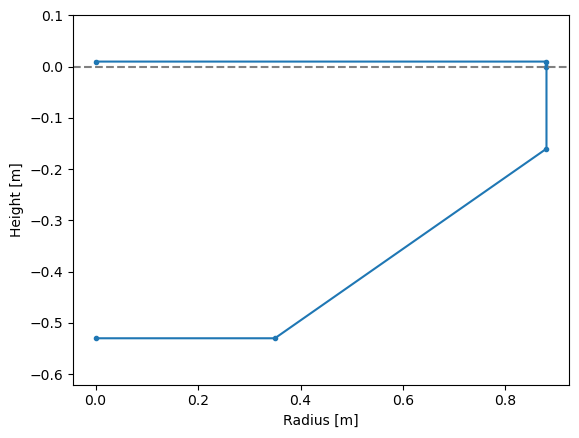

In [30]:
fb.show_matplotlib()
_ = wb.plot_cross_section(show=True)  # specific to WaveBot

#### Frequency and mesh check
We will analyze 50 frequencies with a spacing of 0.05 Hz. These frequencies will be used for the Fourier representation of both the wave and the desired PTO force in the pseudo-spectral problem. See the Theory section of the Documentation for more details on the pseudo-spectral problem formulation.

The `fb.minimal_computable_wavelength` parameter checks the mesh to determine the minimum wavelength that can be reliably computed using Capytaine. This warning is ignored here because the BEM results have been validated, but can be used as a guide for mesh refinement to ensure accurate BEM results.

In [31]:
f1 = 0.8/80
nfreq = 80
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

min_computable_wavelength = fb.minimal_computable_wavelength
g = 9.81
min_period = 1/(f1*nfreq)
min_wavelength = (g*(min_period)**2)/(2*np.pi)

if min_wavelength < min_computable_wavelength:
    print(f'Warning: Minimum wavelength in frequency spectrum ({min_wavelength}) is smaller'
         f' than the minimum computable wavelength ({min_computable_wavelength}).')

#### BEM
With our Capytaine floating body created, we can now run the Boundary Element Method solver in Capytaine to get the hydrostatic and hydrodynamic coefficients of our WEC object. This is wrapped into the `wecopttool.run_bem` function.

If you would like to save our BEM data to a NetCDF file for future use, see the `wecopttool.write_netcdf` function.

In [32]:
bem_data = wot.run_bem(fb, freq)

('Heave', 'Heave')


#### PTO
WecOptTool includes the `PTO` class to encompass all properties of the power take-off system of the WEC. Data wrapped into our `PTO` class will be used to help define our `WEC` object and optimization problem later.

To create an instance of the `PTO` class, we need:
- The kinematics matrix, which converts from the WEC degrees of freedom to the PTO degrees of freedom. The PTO extracts power directly from the WEC's heave in this case, so the kinematics matrix is simply the $1 \times 1$ identity matrix.
- The definition of the PTO controller. The `wecopttool.pto` submodule includes P, PI, and PID controller functions that can be provided to the `PTO` class and return the PTO force. However, we will be using an unstructured controller in this case, so we will set `None` for the controller.
- Any PTO impedance. We're only interested in mechanical power for this first problem, so we will leave this empty for now
- The non-linear power conversion loss (assumed 0% if `None`)
- The PTO system name, if desired

In [33]:
## PTO impedance definition
omega = bem_data.omega.values
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*omega*drivetrain_inertia +
                        drivetrain_friction +
                        1/(1j*omega)*drivetrain_stiffness)

winding_impedance = winding_resistance + 1j*omega*winding_inductance


pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])

In [34]:
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None #wot.pto.controller_pi
loss = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)

Now let's define the PTO forcing on the WEC and the PTO constraints. For our optimization problem, the constraints must be in the correct format for `scipy.optimize.minimize()`. We will enforce the constraint at 4 times more points than the dynamics (see Theory for why this is helpful for the pseudo-spectral problem).

In [35]:
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 200
nsubsteps = 4

# other constraints
pos_max = 0.075
vel_max = 0.4
rms_max = 200

# constraint the peak pto force
def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

# constraint peak position
def const_pos_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    pos = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
    return pos_max - np.abs(pos.flatten())

# constraint peak position
def const_vel_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_max - np.abs(vel.flatten())

# constraint rms force
def const_f_rms_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    f_rms = np.sqrt(np.mean(f.flatten()**2))
    return rms_max - f_rms

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

#### `WEC` creation
We are now ready to create the `WEC` object itself! Since we ran our BEM already, we can define the object using the `wecopttool.WEC.from_bem` function. If we saved our BEM data to a NetCDF file, we can also provide the path to that file instead of specifying the BEM `Dataset` directly.

In [36]:
wec = wot.WEC.from_bem(
    bem_data,
    constraints=constraints,
    friction=None,
    f_add=f_add,
    uniform_shift=False,
)

Note: We might receive a warning regarding negative linear damping values. Per default, WecOptTool ensures that the BEM data does not contain non-negative damping values. If you would like to correct the BEM solution manually to a minimum damping value you can specify `min_damping`. 

### Waves
The wave environment must be specified as a 2-dimensional `xarray.DataArray` containing the complex amplitude (m). 
The two coordinates are the radial frequency ``omega`` (rad/s)  and the direction ``wave_direction`` (rad). 
The `wecopttool.waves` submodule contains functions for creating this `xarray.DataArray` for different types of wave environments. 

In this case we will use a regular wave with a frequency of 0.3 Hz and an amplitude of 0.0625 m. 
We will use the `wecopttool.waves.regular_wave` function. 

In [37]:
amplitude = 0.0625  
wavefreq = 0.3
phase = 30
wavedir = 0
waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

# irregular
Hs = .4
Tp = 10
nrealizations = 1

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)

In [39]:
df = f1
values = efth.values
values[values<0] = np.nan
amplitudes = np.sqrt(2 * values * df)
amplitudes = np.expand_dims(amplitudes,axis=2)

attr = {
        'Wave type': 'Long-crested irregular',
        'Direction (degrees)': wavedir,
    }

print(np.shape(amplitudes))
phase = 123*np.ones((nfreq,1,1))
print(np.shape(phase))

seed = None

wave_irreg_elev = wot.waves.elevation_fd(f1, nfreq, wavedir, nrealizations, amplitudes, phase, attr, seed)

(80, 1, 1)
(80, 1, 1)


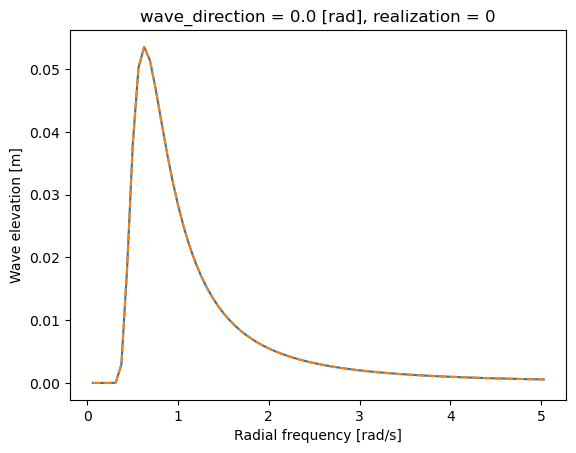

In [40]:
fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

plt2 = np.abs(wave_irreg_elev.sel(realization=0)).plot(
    ax=ax, color='C1',ls='--')

### Objective function
The objective function is the quantity (scalar) we want to optimize—in this case, the average mechanical power. The objective function is itself a function of the optimization state, the size of which we need to properly define our call to `scipy.optimize.minimize()`. The average mechanical power can be taken directly from the `PTO` object we created.

One technical quirk here: `nstate_opt` is one smaller than would be expected for a state space representing the mean (DC) component and the real and imaginary Fourier coefficients. This is because WecOptTool excludes the imaginary Fourier component of the highest frequency (the 2-point wave). Since the 2-point wave is sampled at multiples of $\pi$, the imaginary component is evaluated as $sin(n\pi); n = 0, 1, 2, ..., n_{freq}$, which is always zero. Excluding this component speeds up the optimization as the state space is reduced by one.

In [41]:
obj_fun = pto.average_power
nstate_opt = 2*nfreq

### Solve
We are now ready to solve the problem. WecOptTool uses `scipy.optimize.minimize` as its optimization driver, which is wrapped into `wecopttool.WEC.solve` for ease of use.

Note that the only required inputs for defining and solving the problem are: (1) the waves, (2) the objective function, and (3) the size of the optimization state. Optional inputs can be provided to control the optimization execution if desired, which we do here to change the default iteration maximum and tolerance. See `scipy.optimize.minimize` docs for more details.

To help the optimization we will scale the problem before solving it (see Documentation). WecOptTool allows you to scale the WEC dynamics state, your optimization state (in this case the Fourier coefficients for the PTO force), and the objective function separately. See the `wecopttool.WEC.solve()` function for more information.


Pay attention to the `Exit mode`: an exit mode of $0$ indicates a successful solution. For an easy problem (linear, single Dof, unconstrained, etc.) your iterations shouldn't need to exceed 100. If they do, try adjusting the scales by orders of magnitude, one at a time.

In [42]:
import logging
#logging.basicConfig(level=logging.INFO)

options = {'maxiter': 200}
scale_x_wec = 1e2
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves_irregular, 
    obj_fun, 
    nstate_opt,
    optim_options=options, 
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    )

opt_mechanical_average_power = results[0].fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power} W')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1029307886048764
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimal average mechanical power: -10.29307886048764 W


### Analyzing results
We will use two post-processing functions to obtain frequency- and time-domain results for the WEC and PTO responses. The pseudospectral method gives continuous in time results. To get smoother looking plots, we specify the number of subpoints betweeen co-location points. In this case we will use 5. 

In [43]:
nsubsteps = 5
pto_fdom, pto_tdom = pto.post_process(wec, results[0], waves_irregular.sel(realization=0), nsubsteps=nsubsteps)
wec_fdom, wec_tdom = wec.post_process(results[0], waves_irregular.sel(realization=0), nsubsteps=nsubsteps)

The `pto.post_process` function returns `xarray.Dataset`s, which have built-in integration with PyPlot for smart plotting that automagically sets titles and formatting. We will plot the mechanical power (`mech_power`), position (`pos`), and the PTO force (`force`).

<xarray.DataArray 'force' ()>
array(2271.18077527)
Coordinates:
    influenced_dof  <U5 'DOF_0'
    realization     int32 0
    omega           float64 5.027
    freq            float64 0.8
    period          float64 1.25


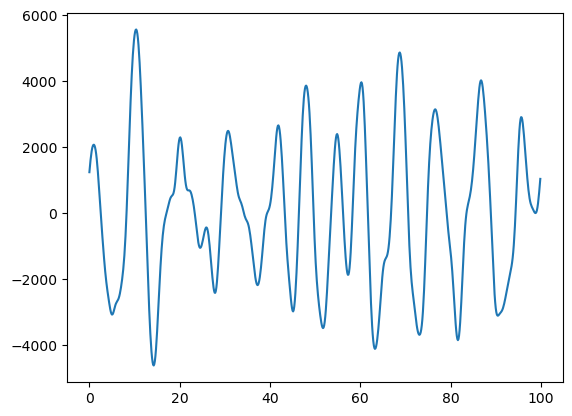

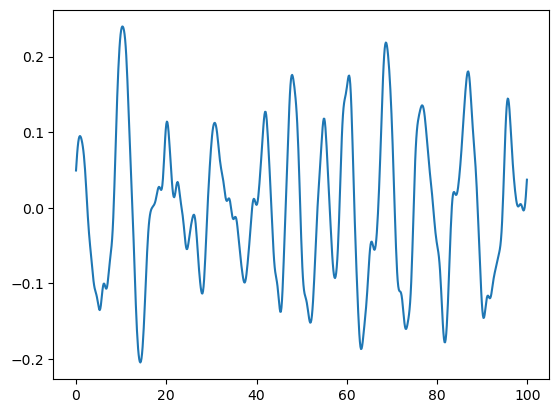

In [44]:
plt.figure()
exc_f =  wec_tdom['force'].sel(type='Froude_Krylov') + wec_tdom['force'].sel(type='diffraction')
plt.plot(wec_tdom['time'],np.squeeze(exc_f))

print(np.sqrt(np.mean(np.squeeze(exc_f)**2)))

plt.figure()
plt.plot(wec_tdom['time'],np.squeeze(wec_tdom['wave_elev']),label=f'realization {0}')

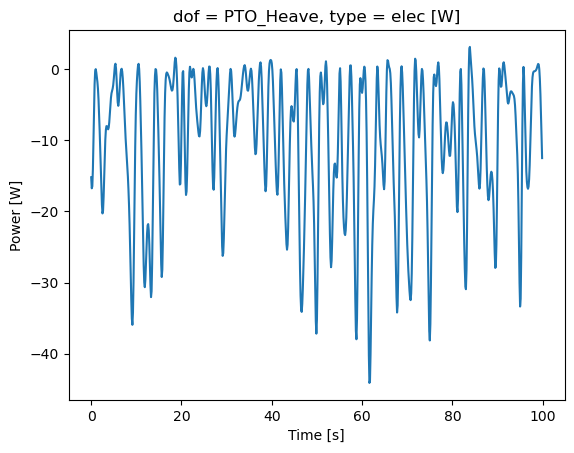

In [45]:
plt.figure()
pto_tdom['power'].loc['elec',:,:].plot()


We could similarly plot any time- or frequency-domain repsonse of the WEC or PTO. For instance, here is the PTO heave motion.

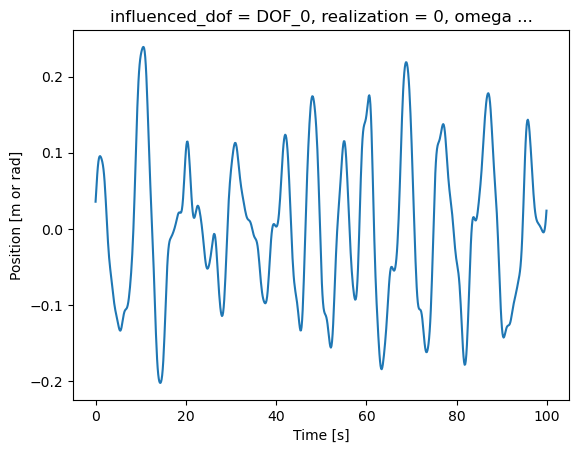

In [46]:
plt.figure()
wec_tdom['pos'].plot()

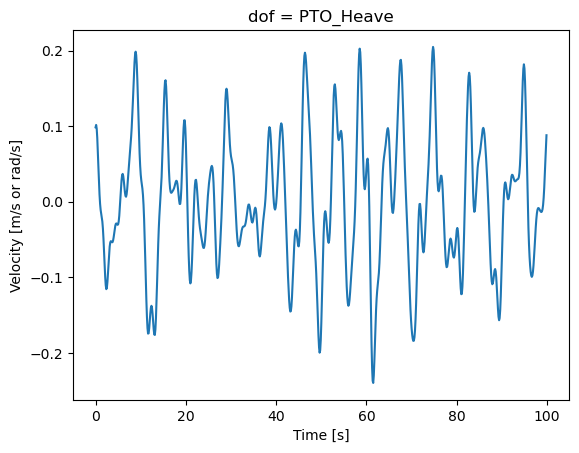

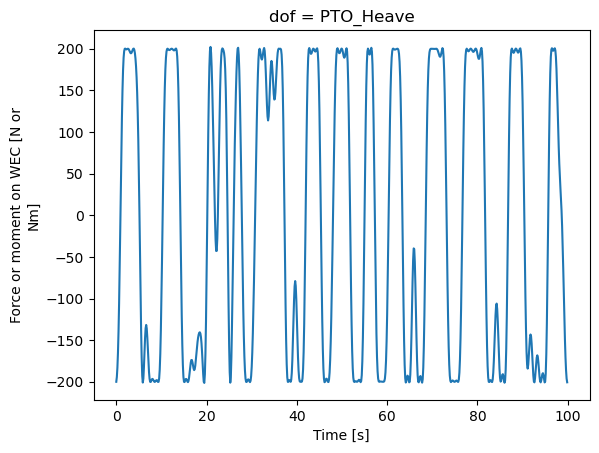

In [47]:
plt.figure()
pto_tdom['vel'].plot()

plt.figure()
pto_tdom['force'].plot()

Text(0.5, 0, 'frequency [rad/s]')

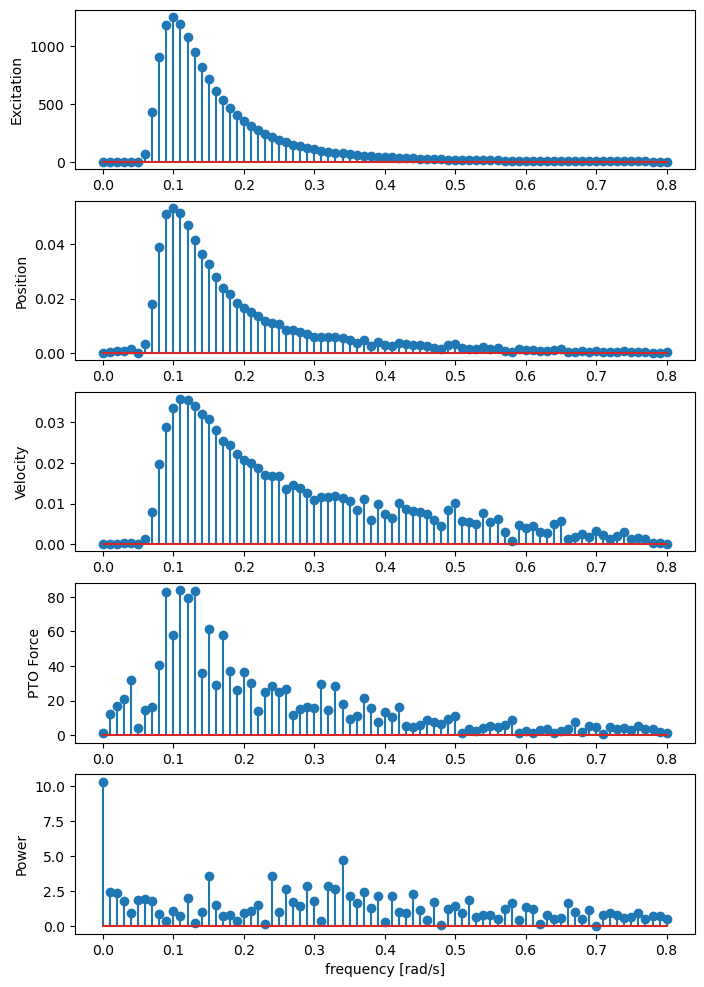

In [48]:
excitation_force = wec_fdom['force'].sel(type='Froude_Krylov') + wec_fdom['force'].sel(type='diffraction')
position = wec_fdom.pos
velocity = wec_fdom.vel
pto_force =  pto_fdom.force
mech_power = pto_fdom.power.sel(type = 'mech')
power = pto_fdom.power.sel(type = 'elec')

fig, ax = plt.subplots(5,1,figsize=(8, 12))

ax[0].stem(wec_fdom['freq'],abs(excitation_force))
ax[0].set_ylabel('Excitation')

ax[1].stem(wec_fdom['freq'],abs(position))
ax[1].set_ylabel('Position')

ax[2].stem(wec_fdom['freq'],abs(velocity))
ax[2].set_ylabel('Velocity')

# Plot PTO force
ax[3].stem(wec_fdom['freq'],abs(pto_force))
ax[3].set_ylabel('PTO Force')

# Plot power
#ax[5].stem(omegas,abs(mech_power))
ax[4].stem(wec_fdom['freq'],abs(power))
ax[4].set_ylabel('Power')
ax[4].set_xlabel('frequency [rad/s]')

Note that there are other dynamic responses available in the post-processed WEC and PTO variables (`wec_tdom`, `pto_tdom`, `wec_fdom`, `pto_fdom`). For example, the time domain PTO variable contains the following response:

## 2. Optimal control for maximum electrical power

The rest of this tutorial will focus on optimizing for electrical power (new objective function) rather than mechanical, as this is a form of power that is usable and transportable.

Since we're still dealing with the same WaveBot as in part 1, we can reuse the BEM and wave data from before. Look back at part 1 if you need a refresher on how to create these data.

<div>
<img src="https://live.staticflickr.com/65535/52435033525_b8efc28d16_k.jpg" width="1000">
</div>
The WEC-PTO kinematics remain the same as well (unity). The major difference now is that we consider the dynamics of PTO, since they impact the electrical power and we shall not assume a lossless PTO.

We will express the PTO's dynamics in form of a 2-port impedance model, to incoporate the dynamics of the drive-train and the dynamics of the generator.
The additional mechanical energy storage through the drive-train is modelled using Newton's second law and we assume a linear generator using a power-invariant park transform.

The PTO impedance matrix components are then obtained under open-circuit  conditions, i.e.  no  load  current  or  no  WEC  velocity,  respectively.

The attentive user might have noticed that the amplitude of the position, force and power signals is about half the magnitude of the signals we plotted in the first part of the tutorial. We can see that optimizing for electrical power requires optimal state trajectories with smaller amplitudes. For most WECs the electrical power is the usable form of power, thus the WEC should be designed for electrical power and we can avoid over-designing, which would results from expecting the forces associated with the optimal trajectories for mechanical power maximisation.

## 3. Control co-design of the WEC geometry for maximum electrical power
The first two examples only used the inner optimization loop in WecOptTool to optimize PTO power. Here in Part 3 we bring it all together and show how to use both the inner and outer optimization loops in WecOptTool to do control co-optimization of a hull design in conjunction with an optimal controller for electrical power.
Again, we use the WaveBot WEC in one degree of freedom in regular waves. 
The goal is to **find the optimal keel radius** (`r2`) that maximizes the average produced electrical power, while maintaining a constant hull volume. 
A constant volume is achieved by setting the height of the conical section (`h2`) in conjunction with the keel radius (`r2`).

This example demonstrates a complete case of the types of optimization studies WecOptTool is meant for. 
The main optimization (outer optimization loop) is to find the optimal geometry (radius `r2`), and for each geometry considered the optimal PTO force (inner optimization loop) will be found.
The inner loop was showcased in Example 2 and uses a gradient-based optimization method, with the gradients obtained with automatic differentiation. 
The outer loop optimization is for the user to setup. 
In this example, we will do a simple *brute force* optimization using `scipy.optimize.brute`.  

![Device Diagram](https://live.staticflickr.com/65535/51751577441_515afec334_z.jpg) 
<div>
<img src="https://live.staticflickr.com/65535/52434071157_187eb4334c_k.jpg" width="1000">
</div>



### Problem setup
First, we define a function for `h2` based on `r1` that maintains a constant volume. 
We see that, as expected, smaller values of `r2` require larger values of `h2` in order to maintain a constant hull volume.

Next we will define an objective function for our design optimization problem. We use the same workflow illustrated in Part 2 to set up a WaveBot device and solve for the optimal solution, but wrap this in a function definition which can set `r2` and (indirectly) `h2`.

Note that in this case the magnitude of average power between the different keel radii is rather small, this is because the PTO force constraint is active most of the time, therefore all considered geometries perform similarily. If you remove the PTO constraint and re-run the co-optimization study you will see that the impact of radius on average electrical power is significantly higher.

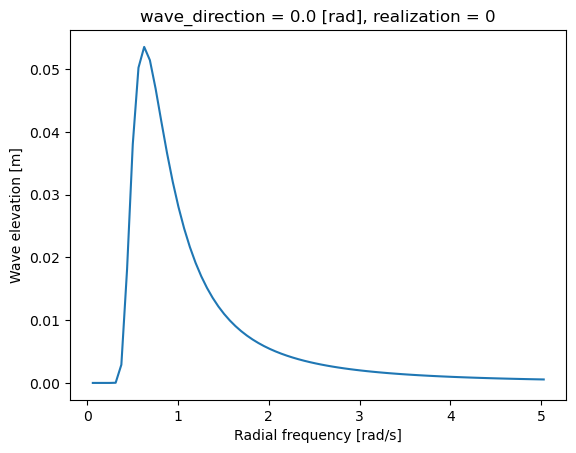

In [49]:
# irregular
Hs = .4
Tp = 10

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")

meanpower = []

waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 100)

fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

In [50]:
# calculate max power
Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
ampSpect = waves_irregular.sel(realization=0).values
Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

hydro_data = wot.add_linear_friction(bem_data)
Zi = wot.hydrodynamic_impedance(hydro_data)

# Maximum Mechanical Power
P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
P_ub = - sum(np.squeeze(P_ub_vec)).values

print(f'Max Theoretical Power: {P_ub}')

Max Theoretical Power: -15039.867925395665


In [ ]:
results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2*nfreq,#*nfreq,
    optim_options=options,
    scale_x_wec=1e2,
    scale_x_opt=1e-4,
    scale_obj=1e-2,
)

power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')



Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10218800291867491
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10444875306392644
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0993436217991979
            Iterations: 32
            Function evaluations: 32
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10068759008127227
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.09819896918739762
            Iterations: 33
            Fun

In [ ]:
max_pos = []
max_vel = []
max_fpto = []
plt.figure()

# calculate the maximum position, velocity, and PTO force
for ind, result in enumerate(results):
    wf, wt = wec.post_process(result, waves_irregular.sel(realization=ind), nsubsteps)
    pf, pt = pto.post_process(wec, result, waves_irregular.sel(realization=ind), nsubsteps)
    
    max_pos.append(max(abs(np.squeeze(wt['pos']).values)))
    max_vel.append(max(abs(np.squeeze(wt['vel']).values)))
    max_fpto.append(max(abs(np.squeeze(pt['force']).values)))
    
    plt.plot(wt['time'],np.squeeze(wt['wave_elev']),label=f'realization {ind}')


#plt.legend()
plt.xlim(0,5)
plt.xlabel('Time [s]')
plt.ylabel('Wave Elevation [m]')

In [ ]:
import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],power_results),pos=(['ind'],max_pos),
                                     vel=(['ind'],max_vel),fpto=(['ind'],max_fpto),
                                     x=(['ind','ind2'],x_results)), 
                    coords=dict(ind=range(len(power_results)),ind2=range(len(x_results[0]))))
res_ds.to_netcdf('wavebot_power_convergence_80f_100r_lowfreq.nc')

In [ ]:
# load results
import xarray as xr
#res_ds = xr.load_dataset('wavebot_power_convergence_100f_30r.nc')

Text(0, 0.5, 'Average Max PTO Force (N)')

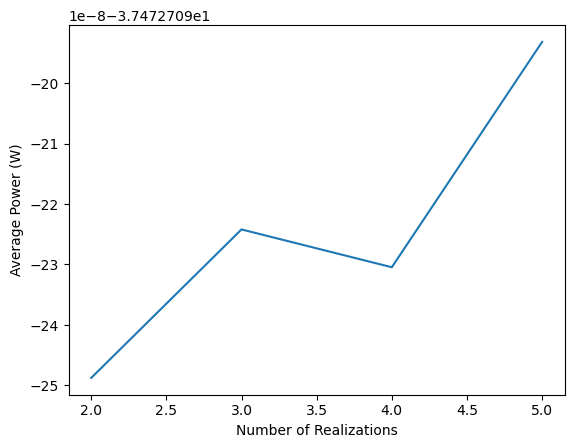

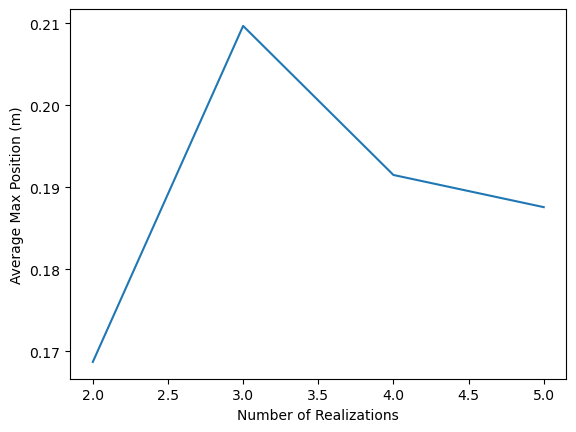

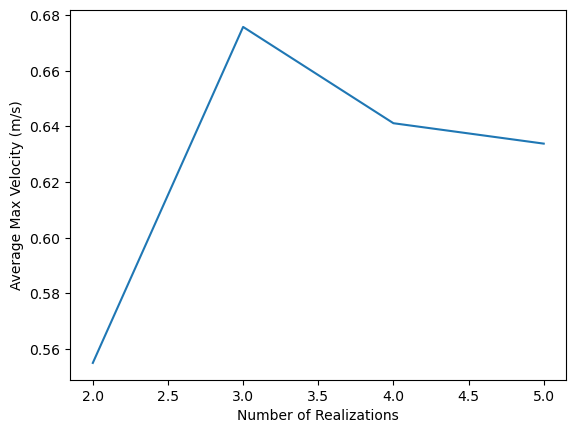

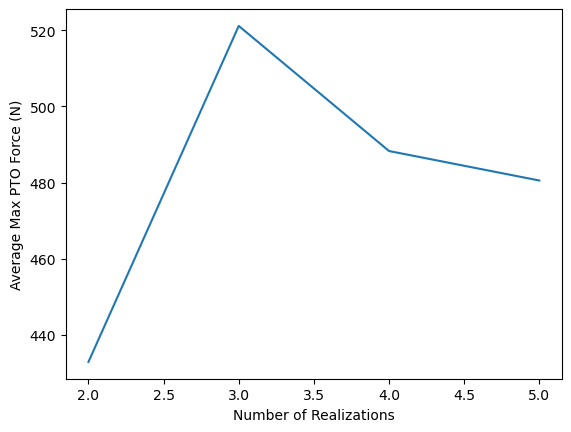

In [27]:
rolling_mean = []
rolling_pos = []
rolling_vel = []
rolling_fpto = []

for ind in range(len(res_ds['power'])):

    rolling_mean.append(np.mean(res_ds['power'][0:ind]))
    rolling_pos.append(np.mean(res_ds['pos'][0:ind]))
    rolling_vel.append(np.mean(res_ds['vel'][0:ind]))
    rolling_fpto.append(np.mean(res_ds['fpto'][0:ind]))
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')
#plt.xlim([75, 90])
#plt.ylim([-90, -75])
#plt.ylim([-28.974, -28.973])

plt.figure()
plt.plot(range(1,len(res_ds['pos'])+1),rolling_pos)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Max Position (m)')

plt.figure()
plt.plot(range(1,len(res_ds['vel'])+1),rolling_vel)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Max Velocity (m/s)')

plt.figure()
plt.plot(range(1,len(res_ds['fpto'])+1),rolling_fpto)
plt.xlabel('Number of Realizations')
plt.ylabel('Average Max PTO Force (N)')

#plt.figure()
#plt.boxplot(res_ds['power'])
#plt.ylim([-28.974, -28.973])

Text(0.5, 0, 'Number of Realizations')

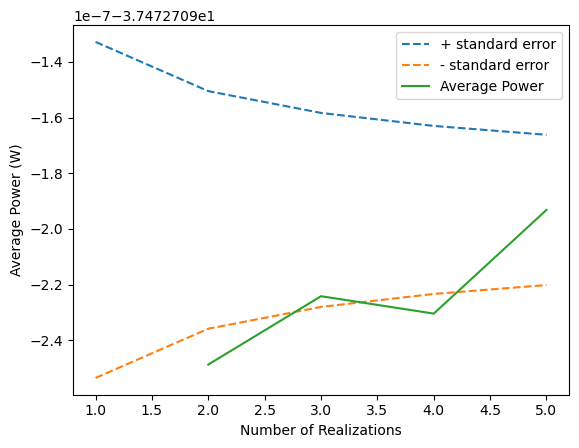

In [28]:
rolling_sem = []
rolling_var = []

stdev = np.std(res_ds['power'])

for ind in range(len(res_ds['power'])):
    
    #stdev = np.std(res_ds['power'][0:ind])
    
    rolling_var.append(stdev**2)
    
    rolling_sem.append(stdev/np.sqrt(ind+1))
    
rolling_sem_pos = [sum(x) for x in zip(rolling_sem, rolling_mean)]
rolling_sem_neg = [y-x for x, y in zip(rolling_sem, rolling_mean)]

rolling_sem_pos = [sum(x,rolling_mean[-1]) for x in zip(rolling_sem)]
rolling_sem_neg = [rolling_mean[-1]-x for x in rolling_sem]

rolling_var_pos = [sum(x) for x in zip(rolling_var, rolling_mean)]
rolling_var_neg = [y-x for x, y in zip(rolling_var, rolling_mean)]
    
plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_pos,'--',label='+ standard error')
plt.plot(range(1,len(res_ds['power'])+1),rolling_sem_neg,'--',label='- standard error')
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_pos)
#plt.plot(range(1,len(res_ds['power'])+1),rolling_var_neg)
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean,label='Average Power')
plt.legend()
plt.ylabel('Average Power (W)')
plt.xlabel('Number of Realizations')

Text(0, 0.5, 'Integral Gain')

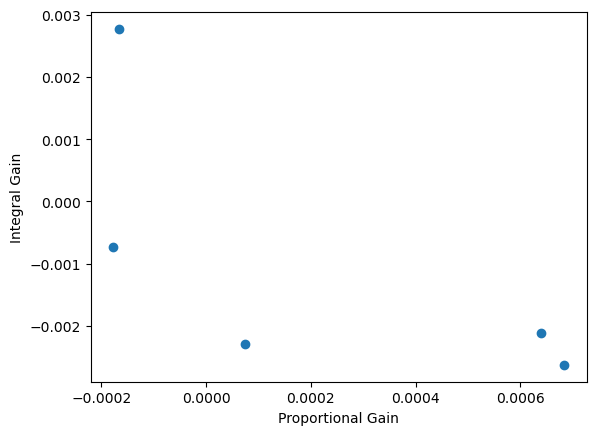

In [29]:
x_opts = []

for x in res_ds['x']:
    x_wec, x_opt = wec.decompose_state(x)
    x_opts.append(x_opt.to_numpy())

x_opts = np.array(x_opts)

x_diff = x_opts[-1] - x_opts[0]
#print(x_opts)

plt.figure() 
plt.scatter(-x_opts[:,0],-x_opts[:,1])
plt.xlabel('Proportional Gain')
plt.ylabel('Integral Gain')

In [96]:
# Now, calculate the mean P and I gains and plug them back into each of the realizations to see the total average power

# calculate mean P and I gains
mean_p = np.mean(x_opts[:,0])
print(mean_p)
mean_i = np.mean(x_opts[:,1])
print(mean_i)

# set equality constraints on the P and I gains
constraints = []

bounds = ((mean_p,mean_p),(mean_i,mean_i))

# Create WEC
wec = wot.WEC.from_bem(bem_data,
        constraints=constraints,
        friction=None, 
        f_add=f_add,
        )

results = wec.solve(
    waves_irregular,
    obj_fun,
    nstate_opt=2,
    scale_x_wec=1e1,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
    bounds_opt=bounds,
)
power_results = [result.fun for result in results]
x_results = [result.x for result in results]
print(f'Optimal average power: {np.mean(power_results):.2f} W')

NameError: name 'x_opts' is not defined

In [ ]:
rolling_mean_const_PI = []

for ind in range(len(res_ds['power'])):

    rolling_mean_const_PI.append(np.mean(power_results[0:ind]))

plt.figure()
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean, label = 'variable PI gains')
plt.plot(range(1,len(res_ds['power'])+1),rolling_mean_const_PI, label = 'mean PI gains')
plt.legend()
plt.xlabel('Number of Realizations')
plt.ylabel('Average Power (W)')

In [ ]:
wf1, wt1 = wec.post_process(results[0], waves_irregular.sel(realization=0), nsubsteps)
pf1, pt1 = pto.post_process(wec, results[0], waves_irregular.sel(realization=0), nsubsteps)

wf2, wt2 = wec.post_process(results[1], waves_irregular.sel(realization=1), nsubsteps)
pf2, pt2 = pto.post_process(wec, results[1], waves_irregular.sel(realization=1), nsubsteps)

plt.figure()
pt1['force'].plot()

plt.figure()
pt2['force'].plot()

consResults = []

for ind, result in enumerate(results):
    wf, wt = wec.post_process(result, waves_irregular.sel(realization=ind), nsubsteps)
    pf, pt = pto.post_process(wec, result, waves_irregular.sel(realization=ind), nsubsteps)
    consResults.append(np.any(abs(pt['force']) > f_max))
    print(ind)

print(sum(consResults))
print(400-sum(consResults))

[ 50.  75. 100. 125. 150. 175. 200. 225. 250. 275. 300.]
('Heave', 'Heave')
Max Theoretical Power: -15025.633996464321


('Heave', 'Heave')


Max Theoretical Power: -15038.365711621214
('Heave', 'Heave')
Max Theoretical Power: -15039.351679702306


('Heave', 'Heave')


Max Theoretical Power: -15039.371409311083
('Heave', 'Heave')


Max Theoretical Power: -15039.370080127852
('Heave', 'Heave')
Max Theoretical Power: -15039.370360804083


('Heave', 'Heave')
Max Theoretical Power: -15039.370462455377


('Heave', 'Heave')


Max Theoretical Power: -15039.370057259543
('Heave', 'Heave')


Max Theoretical Power: -15039.370154750211
('Heave', 'Heave')
Max Theoretical Power: -15039.370214122555


('Heave', 'Heave')
Max Theoretical Power: -15039.370301696868


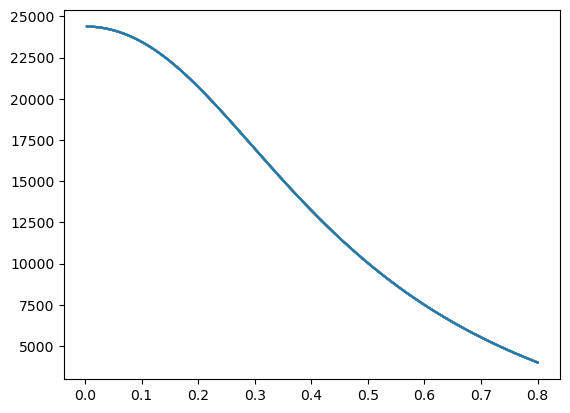

In [24]:
nfreqs = np.linspace(50,300,11)
fend = 0.8
print(nfreqs)

# irregular
Hs = .4
Tp = 10

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
Pmaxs = []

plt.figure()

for nfreq in nfreqs:
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)
    
    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
        uniform_shift=False,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    
    plt.plot(freq,np.squeeze(abs(Fe)))
    
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values

    Pmaxs.append(P_ub)
    print(f'Max Theoretical Power: {P_ub}')
    

[-15025.633996464321, -15038.365711621214, -15039.351679702306, -15039.371409311083, -15039.370080127852, -15039.370360804083, -15039.370462455377, -15039.370057259543, -15039.370154750211, -15039.370214122555, -15039.370301696868]


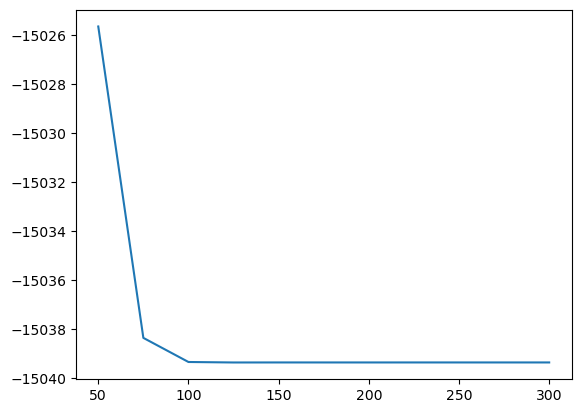

In [25]:
print(Pmaxs)
plt.figure()
plt.plot(nfreqs,Pmaxs)

In [23]:
import time
import logging
#logging.basicConfig(level=logging.INFO)

# compare run times vs. number of frequencies
nfreqs = np.linspace(20,300,15)
fend = .8

runtime = []
meanpower = []
Pmaxs = []

name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None
loss = None
pto_impedance = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, loss, name)
# PTO dynamics forcing function
f_add = {'PTO': pto.force_on_wec}

# Constraint
f_max = 200
nsubsteps = 4

def const_f_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
    f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
    return f_max - np.abs(f.flatten())

ineq_cons = {'type': 'ineq',
             'fun': const_f_pto,
             }
constraints = [ineq_cons]

# irregular
Hs = .4
Tp = 10

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

#nrealizations = 20
minutes_needed=20

scale_x_wec = 1e2
scale_x_opt = 1e-3
scale_obj = 1e-2
options = {'maxiter': 400}

# run each simulation for 20 minutes

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )
    
    sim_time = (1/(fend/nfreq))
    nrealizations_needed = minutes_needed*60/sim_time
    nrealizations_needed = np.round(nrealizations_needed)

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = int(nrealizations_needed))
    
    print(f'nfreq: {nfreq}')
    starttime = time.time()
    
    obj_fun = pto.average_power
    nstate_opt = 2*int(nfreq)
    
    results = wec.solve(
        waves_irregular,
        obj_fun,
        nstate_opt=nstate_opt,
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
    )
    
    power_results = [result.fun for result in results]
    x_results = [result.x for result in results]
    print(f'Optimal average power: {np.mean(power_results):.2f} W')
    
    meanpower.append(np.mean(power_results))
    
    endtime = time.time()
    runtime.append(endtime-starttime)
    print(runtime)
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)
    
import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=nfreqs))
res_ds.to_netcdf('wavebot_freq_time_lowfreqs.nc')

('Heave', 'Heave')
nfreq: 20.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12761218020163587
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12288052544575767
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12075922650797209
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12667430308539257
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12623871349577961
          

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13082782771044824
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11377933147353737
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13053689719296674
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1312753604722883
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10890044501374697
            Iterations: 38
            Fun

('Heave', 'Heave')
nfreq: 40.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11967940474585335
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12110035605322944
            Iterations: 39
            Function evaluations: 39
            Gradient evaluations: 39
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12558094092374295
            Iterations: 34
            Function evaluations: 35
            Gradient evaluations: 34
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12218597337323708
            Iterations: 42
            Function evaluations: 42
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13322575814763069
          

('Heave', 'Heave')
nfreq: 60.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12987237233419743
            Iterations: 42
            Function evaluations: 43
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1271488708603459
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1244738816095695
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12352592755237607
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11937299058672322
            

('Heave', 'Heave')
nfreq: 80.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1268837604214448
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12333270155423759
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11233228312360506
            Iterations: 47
            Function evaluations: 48
            Gradient evaluations: 47
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11974598087770379
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12522934120144874
           

('Heave', 'Heave')
nfreq: 100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12130203715431943
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12174064929206611
            Iterations: 42
            Function evaluations: 42
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1258909591327033
            Iterations: 38
            Function evaluations: 39
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12412476137667439
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12126256665059373
          

('Heave', 'Heave')
nfreq: 120.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1212396178182074
            Iterations: 42
            Function evaluations: 42
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12513687618094146
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12538634823271058
            Iterations: 40
            Function evaluations: 40
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12243417455474541
            Iterations: 41
            Function evaluations: 41
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12478744709599035
          

('Heave', 'Heave')
nfreq: 140.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12604088406065658
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12731533276494963
            Iterations: 44
            Function evaluations: 45
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1257966015248391
            Iterations: 43
            Function evaluations: 44
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12030964522855071
            Iterations: 45
            Function evaluations: 45
            Gradient evaluations: 45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12029428995952435
          

('Heave', 'Heave')
nfreq: 160.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12367888817364049
            Iterations: 40
            Function evaluations: 41
            Gradient evaluations: 40
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12667555108611697
            Iterations: 42
            Function evaluations: 43
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12340095756834686
            Iterations: 42
            Function evaluations: 43
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12537607630072997
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12368270252920378
         

('Heave', 'Heave')
nfreq: 180.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12009102930976016
            Iterations: 43
            Function evaluations: 45
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1258521334422161
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12333783209611288
            Iterations: 44
            Function evaluations: 44
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1240168707229881
            Iterations: 41
            Function evaluations: 41
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1217551504963682
            

('Heave', 'Heave')
nfreq: 200.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12508294926715316
            Iterations: 37
            Function evaluations: 37
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12736541920256156
            Iterations: 41
            Function evaluations: 41
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12478337277636362
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12268020431758304
            Iterations: 36
            Function evaluations: 36
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12291531551333719
         

('Heave', 'Heave')
nfreq: 220.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12400345440083411
            Iterations: 44
            Function evaluations: 44
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12227921484794536
            Iterations: 43
            Function evaluations: 44
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.11969401748177909
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12543931125743407
            Iterations: 40
            Function evaluations: 43
            Gradient evaluations: 40
Optimal average power: -12.29 W
[212.88853192329407, 258.86899876594543, 322.5691647529602, 417.51254057884216, 439.2326

('Heave', 'Heave')
nfreq: 240.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12182257454588034
            Iterations: 41
            Function evaluations: 43
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12682800647646855
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1254763513939824
            Iterations: 44
            Function evaluations: 45
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12483611580934609
            Iterations: 40
            Function evaluations: 42
            Gradient evaluations: 40
Optimal average power: -12.47 W
[212.88853192329407, 258.86899876594543, 322.5691647529602, 417.51254057884216, 439.23261

('Heave', 'Heave')
nfreq: 260.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12554569154371667
            Iterations: 46
            Function evaluations: 47
            Gradient evaluations: 46
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12549846868388487
            Iterations: 44
            Function evaluations: 45
            Gradient evaluations: 44
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12480505520991758
            Iterations: 38
            Function evaluations: 39
            Gradient evaluations: 38
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12325617545377465
            Iterations: 47
            Function evaluations: 47
            Gradient evaluations: 47
Optimal average power: -12.48 W
[212.88853192329407, 258.86899876594543, 322.5691647529602, 417.51254057884216, 439.2326

('Heave', 'Heave')
nfreq: 280.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1241236988327638
            Iterations: 37
            Function evaluations: 38
            Gradient evaluations: 37
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1233620959854431
            Iterations: 43
            Function evaluations: 43
            Gradient evaluations: 43
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12377355321582853
            Iterations: 46
            Function evaluations: 46
            Gradient evaluations: 46
Optimal average power: -12.38 W
[212.88853192329407, 258.86899876594543, 322.5691647529602, 417.51254057884216, 439.2326123714447, 512.0259811878204, 637.7236199378967, 1028.4498600959778, 849.1198689937592, 1053.5422339439392, 1199.76540017128, 1825.8355016708374, 2224.837720632553, 2851.0331382751465]


('Heave', 'Heave')
nfreq: 300.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12399857800136889
            Iterations: 41
            Function evaluations: 44
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12435269090014664
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12297255399986735
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41
Optimal average power: -12.38 W
[212.88853192329407, 258.86899876594543, 322.5691647529602, 417.51254057884216, 439.2326123714447, 512.0259811878204, 637.7236199378967, 1028.4498600959778, 849.1198689937592, 1053.5422339439392, 1199.76540017128, 1825.8355016708374, 2224.837720632553, 2851.0331382751465, 3766.301475048065]


In [ ]:
print(meanpower)
print(runtime)
print(Pmaxs)

import xarray as xr

res_ds = xr.Dataset(data_vars = dict(power=(['ind'],meanpower),time=(['ind'],runtime),pmax=(['ind'],Pmaxs)), 
                    coords=dict(ind=range(len(meanpower))))
res_ds.to_netcdf('wavebot_freq_time_lowfreqs.nc')



In [ ]:
# Plot the computation time vs. number of frequencies

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(nfreqs,runtime)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Computation time (s)')

# also plot total time
tperreal = 1/.02

def tick_function(X):
    V = [(1/(fend/nfreq)) for nfreq in X]
    print(V)
    return ["%.1f" % z for z in V]

ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax1.get_xticks()))
ax2.set_xlabel('Simulation time (s)')

In [ ]:
# plot total simulation time for each number of frequencies

minutes_needed = 20
sim_times = [(1/(fend/nfreq)) for nfreq in nfreqs]

nrealizations_needed = [minutes_needed*60/sim_time for sim_time in sim_times]

#print(nrealizations_needed.type())
total_times = [a*b for a, b in zip(nrealizations_needed,runtime)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,nrealizations_needed)
ax1.set_xlabel('Number of frequencies in realization')
ax1.set_ylabel('Number of realizations needed (20 min)')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(nfreqs,total_times)
ax1.set_xlabel('Number of Frequencies in Realization')
ax1.set_ylabel('Total computation time needed (20 min)')

In [ ]:
# record the max absorbable power for each wave 

Pmaxs = []
nfreqs = np.linspace(20,100,9)
fend = 2.5
nrealizations = 1

Hs = .4
Tp = 10

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)

for nfreq in nfreqs:
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(fb, freq)

    wec = wot.WEC.from_bem(
        bem_data,
        constraints=constraints,
        friction=None,
        f_add=f_add,
    )

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = nrealizations)
    
    print(f'nfreq: {nfreq}')
    
    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    
    Pmaxs.append(P_ub)

    print(f'Max Theoretical Power: {P_ub}')

In [ ]:
plt.figure()
plt.plot(nfreqs, Pmaxs)